# Classification - Feature engineering
This notebook contains an implementation of the maintenance train dataset ML problem as a multi-class classification problem creating and transforming features from the dataset to achieve best results

This will be achieved by creating different steps in the ML-pipeline that take parameters as input and can produce different attributes from the dataset which will be passed into the ML model:

In [83]:
import pandas as pd
import numpy as np
import ast

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, LeaveOneOut
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import pickle
import warnings

# Supress warnings that appear only after MultiLabelBinarizer encoding event codes that are only present in the test data
warnings.filterwarnings("ignore", message="unknown class(es) .*")
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=UserWarning, message=".*The least populated class in y has only.*")
pd.options.display.max_columns = None
pd.options.display.max_rows = None

Loading the dataset:

In [5]:
df = pd.read_csv('sncb_data_challenge.csv', delimiter=';')
df.events_sequence = df.events_sequence.apply(ast.literal_eval) #transforming column saved as string to list of elements
df.seconds_to_incident_sequence = df.seconds_to_incident_sequence.apply(ast.literal_eval) #transforming column saved as string to list of elements
df.train_kph_sequence = df.train_kph_sequence.apply(ast.literal_eval) #transforming column saved as string to list of elements
df.dj_ac_state_sequence = df.dj_ac_state_sequence.apply(ast.literal_eval)
df.dj_dc_state_sequence = df.dj_dc_state_sequence.apply(ast.literal_eval)
df.vehicles_sequence = df.vehicles_sequence.apply(ast.literal_eval)
df.sample(2)

,incident_id,vehicles_sequence,events_sequence,seconds_to_incident_sequence,approx_lat,approx_lon,train_kph_sequence,dj_ac_state_sequence,dj_dc_state_sequence,incident_type
755,4467983,"[542, 542, 542, 542, 542, 542, 542, 542, 542, ...","[3636, 4120, 4148, 2956, 2956, 2956, 2956, 268...","[-13560, -13545, -13545, -13479, -13452, -1344...",51.015696,4.428577,"[0.0, 0.0, 0.0, 30.6, 35.7, 35.4, 34.9, 34.3, ...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...",13
837,4601697,"[1018, 1018, 1018, 1018, 1018, 1018, 1018, 101...","[2956, 2956, 2956, 2956, 2956, 2956, 2956, 295...","[-14400, -14397, -14386, -14375, -14360, -1435...",49.673145,5.590300,"[108.0, 111.8, 121.4, 122.5, 117.9, 116.4, 116...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...",3


## Cleaning frequent events
Next we remove the most frequent events from `events_sequence`. Those concern events that occur in at least $per$ % of all incidents:

Create class in order to optimize the percentage threshold of frequent events to be filtered. This class will be a separate step in the ML pipeline

This class takes as a parameter a percentage $per$. This percentage is the threshold that concerns the most frequent events. Frequent events are defined as events that happen at least once in most incidents. For example, a threshold of 85%, will filter out all the event codes that happen at least once in more than 85% of the incidents.

By doing that, we will optimize this $per$ parameter with fine-tuning to find the percentage that produces the best results for our metric. This filtering only concerns the tf-idf vectorizer: 

In [8]:
class OptimizeCleanFrequentEvents(BaseEstimator, TransformerMixin):
    def __init__(self, per=100):
        self.per = per
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        events_types_dict = {}
        for events_sequence in X_new['events_sequence']:
            row_list = events_sequence
            unique_events = set(row_list)
            for event in unique_events:
                if not events_types_dict.get(event):
                    events_types_dict[event] = 0
                events_types_dict[event] += 1
        sorted_dict = dict(sorted(events_types_dict.items(), key=lambda item: item[1], reverse=True))
        sorted_events_perc_df = pd.DataFrame(list(sorted_dict.items()), columns=['event_type', 'frequency'])
        sorted_events_perc_df['percentage'] = sorted_events_perc_df['frequency'] / X.shape[0] * 100
        sorted_events_perc_df['event_type'] = sorted_events_perc_df['event_type'].astype(str)
        events_low_frequency = list(map(int, list(sorted_events_perc_df[sorted_events_perc_df.percentage<=self.per].event_type)))
        X_new['clean_events_sequence'] = X.events_sequence.apply(lambda x: [i for i in x if i in events_low_frequency]).astype(str)\
                .replace(r'[\[\],]', '', regex=True)
        return X_new

## Number of vehicles
As explored in the exploratory analysis some incidents are connected to train sequences that consist of multiple vehicles

That's why one attribute we create is the number of vehicles for that particular incident

In [10]:
# Transform to set to remove duplicates and then calculate number of unique items of set
df['number_vehicles'] = df['vehicles_sequence'].apply(set).apply(len)

Let's check the `events_sequence`, `vehicles_sequence`, `seconds_to_incident_sequence` of an incident with multiple vehicles. Unfortunately, the seconds are not ordered which means that the various lists do not have the events in a ordered chronological way but they are only ordered for the same vehicles. Meaning seconds are ordered for the first vehicles and then right after follow the ordered seconds for the second vehicle and so on. We can see that in an example with the second incident :

In [12]:
pd.DataFrame({
        'vehicles_sequence': df.loc[1, 'vehicles_sequence'],
        'seconds_to_incident_sequence': df.loc[1, 'seconds_to_incident_sequence'],
        'events_sequence': df.loc[1, 'events_sequence'],
    })

,vehicles_sequence,seconds_to_incident_sequence,events_sequence
0,526,-8573,2744
1,526,-8573,4148
2,526,-8032,4394
3,526,-8032,1566
4,526,-8032,1570
5,526,-7859,4396
6,526,-6146,3634
7,526,-5862,4124
8,526,-5651,2956
9,526,-5634,2956


We will order all seconds to the actual chronological order and together with that we will order correspondingly all the other list attributes since those are connected to the particular timestamp (seconds). For example, the lists `seconds_to_incident_sequence` [-5, -1, 1] and `events_sequence` [4394, 1566, 1570] mean that:
- The event 4394 happened -5 sec before the incident
- The event 1566 happened -1 sec before the incident
- The event 1570 happened 1 sec after the incident

The idea for doing this is that we will try to create new attributes that will contains specific information right before the incident happened (time: 0 sec). For multi-vehicle incidents that would be possible since those were not sorted chronologically:

In [14]:
# Function to sort seconds_to_incident_sequence and reorder other columns accordingly
def sort_and_reorder(row):
    # Sort column and get the sorted indices while keeping the current order for equal elements
    sorted_indices = np.lexsort((np.arange(len(row['seconds_to_incident_sequence'])), row['seconds_to_incident_sequence']))
    
    # Apply the sorted indices to all desired columns
    sorted_seconds = [row['seconds_to_incident_sequence'][i] for i in sorted_indices]
    reordered_vehicles = [row['vehicles_sequence'][i] for i in sorted_indices]
    reordered_events = [row['events_sequence'][i] for i in sorted_indices]
    reordered_speed = [row['train_kph_sequence'][i] for i in sorted_indices]
    reordered_dj_ac = [row['dj_ac_state_sequence'][i] for i in sorted_indices]
    reordered_dj_dc = [row['dj_dc_state_sequence'][i] for i in sorted_indices]
       
    
    return pd.Series([sorted_seconds, reordered_vehicles, reordered_events, reordered_speed,
                     reordered_dj_ac, reordered_dj_dc],
                     index=['seconds_to_incident_sequence', 'vehicles_sequence', 'events_sequence',
                               'train_kph_sequence', 'dj_ac_state_sequence', 'dj_dc_state_sequence'])
df[['seconds_to_incident_sequence', 'vehicles_sequence', 'events_sequence',
   'train_kph_sequence', 'dj_ac_state_sequence', 'dj_dc_state_sequence']] =df.apply(sort_and_reorder, axis=1)

### Final events before incident

Now we will create some extra attributes that will describe the last events before the actual occurence of the incident. To do that we will check the `seconds_to_incident_sequence`, and find the list index of the last timestamp before the incident which is the the index of largest negative second in `seconds_to_incident_sequence`. Saving those indexes we will be able to search and find event right before the incident happening.

In [16]:
# Function to find the index of the maximum negative value
def max_negative_index(lst):
    # Filter out negative values and their indices
    neg_values = [(i, x) for i, x in enumerate(lst) if x < 0]
    max_neg_index, max_neg_value = max(neg_values, key=lambda x: x[1])
    return max_neg_index

Find max negative index. Practically since the events are sequential, we only need to find the max negative index. Knowing that, we can find the other events and seconds since the same index of a list in `seconds_to_incident_sequence` and `events_sequence` correspond to the same event and `seconds_to_incident_sequence` are sorted chronologically:

In [18]:
df['max_negative_index'] = df.seconds_to_incident_sequence.apply(max_negative_index)

Now we use one hot encoding to those events to create extra columns that show the presence or absence of those events in the last n events before incident:

We create another class to be passed in the parameter tuning in order to optimize $last\_events$, the number of the last events before the incident. For example, $last\_events =3$ would mean that the three last events before the incident are encoded using MultiLabelBinarizer (since each sample incident can have multiple previous events) and added to the existing attributes

In [21]:
class OptimizeLastEventsNumber(BaseEstimator, TransformerMixin):
    def __init__(self, last_events=1):
        self.last_events = last_events
        self.mlb = MultiLabelBinarizer()
        
    def fit(self, X, y=None):
        X_new = X.copy()
        X_new['event_last_n'] = X_new.apply(lambda row: row['events_sequence'][row['max_negative_index']-self.last_events+1: row['max_negative_index']+1],
                                            axis=1).apply(lambda x: [str(i) for i in x]) # Extract the minus ith element of the column list
        # Fit the MultiLabelBinarizer only on the specified column
        self.mlb.fit(X_new['event_last_n'])
        return self
    
    def transform(self, X):
        X_new = X.copy()
        X_new['event_last_n'] = X_new.apply(lambda row: row['events_sequence'][row['max_negative_index']-self.last_events+1: row['max_negative_index']+1],
                                            axis=1).apply(lambda x: [str(i) for i in x]) # Extract the minus ith element of the column list
        one_hot_encoded = self.mlb.transform(X_new['event_last_n'])
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=self.mlb.classes_, index=X.index)
        # Concatenate the original DataFrame (without the transformed column) and the MultiLabelBinarizer DataFrame
        X_transformed = pd.concat([X, one_hot_df], axis=1)
        return X_transformed

## Train speed before incident
Another attribute will be created using the train speed sequence. Again, we use the `max_negative_index` attribute to detect the train speeds right before the occurrence of the incident
We will again use a parameter $last\_events$ to identify the last_events speeds to be used. Since the speeds correspond to different timestamps we will take the mean speed in the defined last_events:

Again we create another class to optimize this parameter

In [24]:
class OptimizeLastTrainSpeeds(BaseEstimator, TransformerMixin):
    def __init__(self, last_events=1):
        self.last_events = last_events
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        if self.last_events > 0:
            X_new['average_speed_last_events'] = X_new.apply(lambda row: sum(row['train_kph_sequence'][row['max_negative_index']-self.last_events+1:row['max_negative_index']+1]) / self.last_events,  axis=1)
        return X_new

## Powerlines attributes
Next we can also create some attributes regarding the columns `dj_ac_state_sequence` and `dj_dc_state_sequence` which describe the two pantographs of the train. Usually, just one or 0 is up.

Another class to optimize the number of states before the incident. This step in the pipeline will create double the number of boolean attributes as $last\_events$ defined since there will be one boolean variable for each state for each last step :

In [27]:
class OptimizeLastStates(BaseEstimator, TransformerMixin):
    def __init__(self, last_events=1):
        self.last_events = last_events
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        for i in range(self.last_events):
            column_name_ac = 'dj_ac_state_last_' + str(i+1)
            column_name_dc = 'dj_dc_state_last_' + str(i+1)
            X_new[column_name_ac] = X_new.apply(lambda row: row['dj_ac_state_sequence'][row['max_negative_index'] - i], axis=1)
            X_new[column_name_dc] = X_new.apply(lambda row: row['dj_dc_state_sequence'][row['max_negative_index'] - i], axis=1)
        return X_new

## Emergency breaking feature
Now we can calculate a new variable that contains if there was an emergency breaking in the last $n$ events before the incident happened:

Another class to optimize is the check whether there was an emergency break in the $last\_events$ number of events before the incident. This step in the pipeline will create a new boolean attribute that is True if there was an emergency break in the passed $last\_events$

In [30]:
class OptimizeLastCheckEmergencyBreak(BaseEstimator, TransformerMixin):
    def __init__(self, last_events=10):
        self.last_events = last_events
    
    def fit(self, X, y=None):
        return self
        
    def check_value_before_index(self, lst_event, value, index):
        return value in lst_event[index-self.last_events+1:index+1]
        
    def transform(self, X):
        X_new = X.copy()
        if self.last_events > 0:
            X_new['emergency_breaking_last_events'] = X_new.apply(lambda row: self.check_value_before_index(row['events_sequence'], 4080, row['max_negative_index']), axis=1)
        return X_new

## Event sequence
We will calculate the tf-idf in the events_sequence column, which calculates how relevant an event is in a sequence. The meaning increases proportionally to the number of times an event appears in a sequence but is compensated by the event frequency in the sequence.

Since we use multiple different attributes and not all of them should be passed in the TfidfVectorizer, we will define a preprocessor

In [32]:
# Define the column transformer to apply TfidfVectorizer only to 'clean_events_sequence'
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(ngram_range=(1,1)), 'clean_events_sequence')
    ],
    remainder='passthrough'  # This passes the other columns without modification
)

## Remove attributes
As another class, we have one that just removes the unnecessary attributes after the desired attributes have been created from them

In [34]:
class RemoveAttributes(BaseEstimator, TransformerMixin):
    def __init__(self):
        self
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        return X_new.drop(['incident_id', 'vehicles_sequence', 'events_sequence',
                           'seconds_to_incident_sequence', 'approx_lat', 'approx_lon',
                           'train_kph_sequence', 'dj_ac_state_sequence', 'dj_dc_state_sequence',
                           'incident_type', 'max_negative_index'], axis=1) 

Also a class that helps debug is the print attributes class:

In [36]:
class PrintAttributes(BaseEstimator, TransformerMixin):
    def __init__(self):
        self
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print(X.columns)
        return X

## Metric
As a metric f1 score is used. We define a custom f1 function and scorer that allows zero division and calculated the weighted f1 score which accounts for label imbalance

In detail F1 is calculated as:
$$ F1 Score= 2×\frac{Precision×Recall}{Precision+Recall}
​
$$
There are some minority classes with no correct predictions ($recall=0$) resulting in a null value for the whole f1 score when using a non-custom f1 scorer.

In [38]:
# Create a custom f1 function with zero_division parameter
def custom_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Wrap the custom scoring function using make_scorer
f1_scorer = make_scorer(custom_f1_score)

## Random-searchCV for parameter tuning
Next step is the parameter tuning of the pipeline

First we define different sampling strategies to tackle the issue of the imbalanced classes.

In [40]:
target = df['incident_type'].copy() # target column separated
class_counts = target.value_counts()
max_class_count = max(class_counts.values)
# Each non-majority class will have equal samples to n% of the majority class plus their previous samples (n can be checked from the sampling strategy name)
sampling_strategy_grid_10 = {class_counts.index[i]: int(max_class_count * 0.1) + class_counts.values[i]
                     for i in range(len(class_counts.index)) if class_counts.values[i] < max_class_count}
sampling_strategy_grid_15 = {class_counts.index[i]: int(max_class_count * 0.15) + class_counts.values[i]
                     for i in range(len(class_counts.index)) if class_counts.values[i] < max_class_count}
sampling_strategy_grid_20 = {class_counts.index[i]: int(max_class_count * 0.2) + class_counts.values[i]
                     for i in range(len(class_counts.index)) if class_counts.values[i] < max_class_count}
sampling_strategy_grid_25 = {class_counts.index[i]: int(max_class_count * 0.25) + class_counts.values[i]
                     for i in range(len(class_counts.index)) if class_counts.values[i] < max_class_count}
sampling_strategy_grid_30 = {class_counts.index[i]: int(max_class_count * 0.30) + class_counts.values[i]
                     for i in range(len(class_counts.index)) if class_counts.values[i] < max_class_count}

Also the count vectorizer for the events columns:

In [42]:
# Define the column transformer to apply CountVectorizer only to 'clean_events_sequence'
preprocessor_count = ColumnTransformer(
    transformers=[
        ('count', CountVectorizer(ngram_range=(1,1)), 'clean_events_sequence')
    ],
    remainder='passthrough'  # This passes the other columns without modification
)

The pipeline is defined here with the set parameters that we do not want to alter:

In [44]:
pipeline_best = Pipeline([
                    ('last_event_num_columns', OptimizeLastEventsNumber()),
                    ('last_train_speeds_columns', OptimizeLastTrainSpeeds()),
                    ('last_states_columns', OptimizeLastStates()),
                    ('last_check_emergency_break', OptimizeLastCheckEmergencyBreak()),
                    ('clean_frequent_events', OptimizeCleanFrequentEvents(per=85)),
                    ('remove_attributes', RemoveAttributes()),
                    ('count', preprocessor_count),
                    ('adasyn', ADASYN(random_state=1, n_neighbors=1)),
                    ('gradient_boost', GradientBoostingClassifier(random_state=1)),
                    ])

Now we can define all the parameters that we want to fine tune:

In [46]:
param_grid = {
    'last_event_num_columns__last_events': [i for i in range(0,10,2)], # Number of events before the incident for which new columns are created (with event code)
    'last_train_speeds_columns__last_events': [i for i in range(0,15,3)], # Number of events before incident that are considered for calculating the average speed right before incident
    'last_states_columns__last_events': range(0,5), # Number of events before incident for which new columns are created (booleans for specific state)
    'last_check_emergency_break__last_events': [0, 10, 15, 20, 25, 30, 35], # Number of events before the incident checked, if there was an emergency breaking
    'clean_frequent_events__per': [i for i in range(30,100,10)], # Threshold for filtering out the most frequent event codes (100 means no events are filtered out)
    'adasyn__sampling_strategy': ['auto', sampling_strategy_grid_10, sampling_strategy_grid_15, sampling_strategy_grid_20,
                                sampling_strategy_grid_25, sampling_strategy_grid_30],
    'gradient_boost__n_estimators': [100, 150, 200, 250, 300, 400],
    'gradient_boost__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gradient_boost__max_depth': [3, 5, 7],
    'gradient_boost__min_samples_split': [2, 5, 10],
    'gradient_boost__min_samples_leaf': [1, 5, 10],
    'gradient_boost__subsample': [0.6, 0.8, 1.0],
    'gradient_boost__max_features': ['sqrt', 'log2', None] 
}

Last step is to split data into training and testing and run the randomizedsearchCV. Instead of gridsearch, this method is used since the number of hyperparameters is large and it doesn't attempt all combinations, reducing computational load and increasing efficiency. Of course the final parameters are not guaranteed to be the best but when a high number of iterations is set, the results can be very good:

In [48]:
# Split data into train and test to avoid generalization error
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=1, stratify=target)

# Cross-validation strategy set here to replicate results
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

random_search = RandomizedSearchCV(pipeline_best, param_grid, n_iter=1500, cv=cv, n_jobs=7, verbose=3, scoring=f1_scorer,
                                   random_state=1, error_score='raise')

random_search.fit(X_train, y_train)
best_params = random_search.best_params_

# Print the best parameters and the best score
print("Best Parameters:")
pprint.pprint(random_search.best_params_)
print('\n')
print(f'F1: {random_search.best_score_}')
print("St Dev f1:", str(np.std(cross_val_score(random_search.best_estimator_, X_train, y_train, cv=cv, scoring=f1_scorer))))

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
Best Parameters:
{'adasyn__sampling_strategy': {2: 214,
                               3: 100,
                               4: 173,
                               6: 101,
                               7: 99,
                               9: 212,
                               11: 121,
                               14: 244,
                               16: 99,
                               17: 105,
                               99: 270},
 'clean_frequent_events__per': 90,
 'gradient_boost__learning_rate': 0.1,
 'gradient_boost__max_depth': 7,
 'gradient_boost__max_features': 'sqrt',
 'gradient_boost__min_samples_leaf': 10,
 'gradient_boost__min_samples_split': 2,
 'gradient_boost__n_estimators': 400,
 'gradient_boost__subsample': 1.0,
 'last_check_emergency_break__last_events': 20,
 'last_event_num_columns__last_events': 4,
 'last_states_columns__last_events': 0,
 'last_train_speeds_columns__last_events': 6}


F1:

Last, also the accuracy is showcased:

In [50]:
print("Accuracy:", str(np.mean(cross_val_score(random_search.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy'))))
print("St Dev accuracy:", str(np.std(cross_val_score(random_search.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy'))))

Accuracy: 0.7289855072463768
St Dev accuracy: 0.021276543477565562


## Evaluation of model
Now we test the best model on the test data splited before randomsearchCV use the best parameters found and print the classification report:

In [52]:
# Train a new model with the best parameters
best_model = pipeline_best.set_params(**best_params)
best_model.fit(X_train, y_train)

Pipeline(steps=[('last_event_num_columns',
                 OptimizeLastEventsNumber(last_events=4)),
                ('last_train_speeds_columns',
                 OptimizeLastTrainSpeeds(last_events=6)),
                ('last_states_columns', OptimizeLastStates(last_events=0)),
                ('last_check_emergency_break',
                 OptimizeLastCheckEmergencyBreak(last_events=20)),
                ('clean_frequent_events', OptimizeCleanFrequentEvents(per=90))...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('count', CountVectorizer(),
                                                  'clean_events_sequence')])),
                ('adasyn',
                 ADASYN(n_neighbors=1, random_state=1,
                        sampling_strategy={2: 214, 3: 100, 4: 173, 6: 101,
                                           7: 99, 9: 212, 11: 121, 14: 244,
                                           16: 99, 17: 105, 99: 270})),
                ('gradient_boost',
                 GradientBoostingClassifier(max_depth=7, max_features='sqrt',
                                            min_samples_leaf=10,
                                            n_estimators=400,
                                            random_state=1))])

In [53]:
y_pred = best_model.predict(X_test)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"Weighted F1-score: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred, zero_division=1))

Weighted F1-score: 0.6526
              precision    recall  f1-score   support

           2       0.83      0.79      0.81        24
           3       1.00      0.00      0.00         1
           4       0.69      0.56      0.62        16
           6       1.00      0.00      0.00         1
           7       1.00      0.00      0.00         1
           9       0.71      0.65      0.68        23
          11       0.00      0.00      0.00         5
          13       0.77      0.83      0.80        64
          14       0.68      0.57      0.62        30
          16       1.00      0.00      0.00         1
          17       1.00      0.00      0.00         2
          99       0.43      0.63      0.51        35

    accuracy                           0.67       203
   macro avg       0.76      0.34      0.34       203
weighted avg       0.68      0.67      0.65       203



Also the confusion matrix:

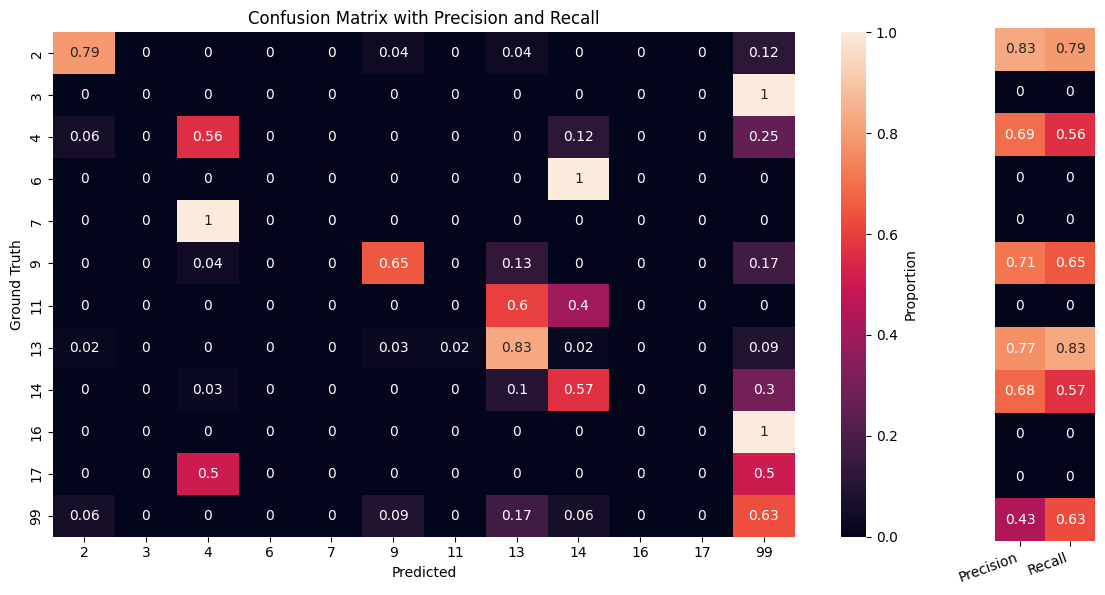

In [55]:
categories = np.unique(y_train)

# Compute confusion matrix
conf_matrix = np.round(confusion_matrix(y_test, y_pred, normalize="true"),2)  # Normalized confusion matrix
precision = precision_score(y_test, y_pred, average=None)  # Per-class precision
recall = recall_score(y_test, y_pred, average=None)        # Per-class recall

# Plot the main confusion matrix
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    cmap="rocket", 
    cbar_kws={'label': 'Proportion'}, 
    xticklabels=categories, 
    yticklabels=categories,
    ax=ax
)
ax.set_xlabel("Predicted")
ax.set_ylabel("Ground Truth")
ax.set_title("Confusion Matrix with Precision and Recall")

# Add precision and recall as a sidebar heatmap
prec_rec = np.array([precision, recall]).T  # Shape (n_classes, 2)
side_ax = ax.figure.add_axes([1, ax.get_position().y0 - 0.02, 0.1, ax.get_position().height + 0.085])  # Match size
sns.heatmap(
    prec_rec, 
    annot=True, 
    cmap="rocket", 
    cbar=False, 
    xticklabels=["Precision", "Recall"], 
    yticklabels=categories,
    vmin=0, 
    vmax=1,
    ax=side_ax
)
side_ax.set_xticklabels(side_ax.get_xticklabels(), rotation=20, ha="right")
side_ax.set_yticks([])  # Remove y-ticks to match visual style

plt.tight_layout()
plt.show()

Last, we saved the trained model:

In [86]:
with open('trained_models/random_pipeline.pkl', 'wb') as file:
    pickle.dump(best_model, file)